# Proof of Concept

Figures to recreate:
* Coverage vs. Atypicality Quantile - for any CP algorithm, data generation, and atypicality score setting 
* Proof of Concept (3x3) - for true atypicality
* Proof of Concept (3x3) - for predicted atypicality
* Distribution of True value in the interval
* Lambda values

In [1]:
import sys
sys.path.append("../src")

from atypicality import compute_atypicality_scores
from data_generation_settings import generate_and_split_gaussian_data, generate_and_split_lognormal_data, generate_and_split_gmm_data
from fit_cp_models import fit_rf_cp_model, fit_gaussian_cp_model, fit_conformal_cp_model
from compute_bounds import evaluate_lambda_adjusted_interval_coverage
from compute_betas import compute_beta
from plotting import plot_coverage_across_atypicality_quantile, plot_betagrouped_by_atypicality

# Calculating Coverage vs. Atypicality Quantile for any experimental setting
In our paper, we use `n_samples = 5000`, and `n_splits=5`.

In [ ]:
atypicality_settings = [
    ('logjointmvn_score', 0),
    # ('lognormal_score', 0.5),
    ('logjointmvn_score', 1)
]

# Run calibration across all atypicality types
coverage_by_quantile_lambda = evaluate_lambda_adjusted_interval_coverage(atypicality_settings, 
                                        make_and_split_data=generate_and_split_gmm_data, 
                                        fit_cp_model=fit_rf_cp_model, 
                                        n_samples=500,
                                        n_splits=3, 
                                        true_atypicality=True,
                                        num_quantiles=5,
                                        silent=True)

# Peek at output: coverage across atypicality score, quantile, split, and lambda
coverage_by_quantile_lambda.head(5)

,score,lambda,quantile,coverage,split
0,logjointmvn_score,0,0,0.90,0
1,logjointmvn_score,0,1,0.85,0
2,logjointmvn_score,0,2,0.85,0
3,logjointmvn_score,0,3,0.55,0
4,logjointmvn_score,0,4,0.80,0


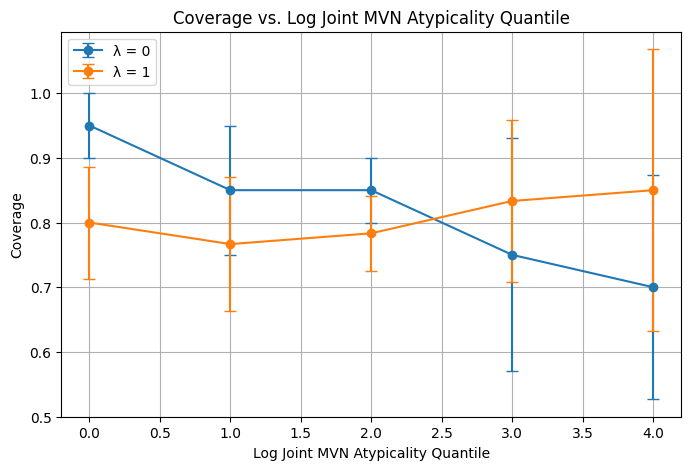

In [37]:
# Plot result for a specific score
plot_coverage_across_atypicality_quantile(df=coverage_by_quantile_lambda,
                                          atypicality_score = "logjointmvn_score",
                                          atypicality_score_title="Log Joint MVN",
                                          ylim_bottom=None,
                                          ylim_top=None,
                                          save=True)

# Calculate $\beta$ for 3x3 Experimental Settings Using Atypicality

,Data Generation Setting,CP Model,Atypicality Score,Lambda,Mean Beta,Std Beta
0,generate_and_split_gaussian_data,fit_rf_cp_model,gmm_score,0,-0.039,0.025100
1,generate_and_split_gaussian_data,fit_rf_cp_model,kde_score,0,0.001,0.018166
2,generate_and_split_gaussian_data,fit_rf_cp_model,knn_score,0,-0.028,0.024648
3,generate_and_split_gaussian_data,fit_rf_cp_model,logjointmvn_score,0,-0.058,0.030125
4,generate_and_split_gaussian_data,fit_gaussian_cp_model,gmm_score,0,-0.029,0.046824


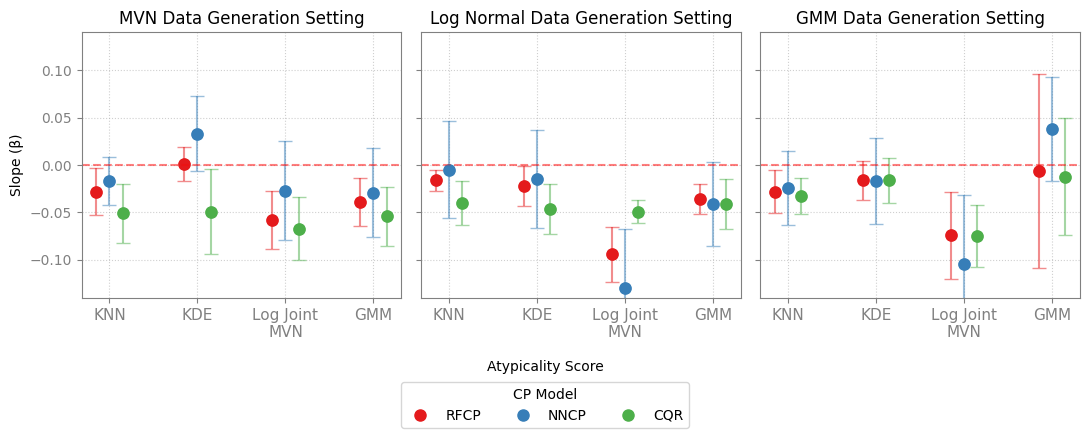

In [ ]:
beta_df = compute_beta(true_atypicality=True, silent=True)
display(beta_df.head(5))
plot_betagrouped_by_atypicality(beta_df, "3x3_atypicality.png")

,Data Generation Setting,CP Model,Atypicality Score,Lambda,Mean Beta,Std Beta
0,generate_and_split_gaussian_data,fit_rf_cp_model,gmm_score,0,-0.016,0.036297
1,generate_and_split_gaussian_data,fit_rf_cp_model,kde_score,0,-0.011,0.025100
2,generate_and_split_gaussian_data,fit_rf_cp_model,knn_score,0,-0.014,0.011937
3,generate_and_split_gaussian_data,fit_rf_cp_model,logjointmvn_score,0,-0.021,0.024083
4,generate_and_split_gaussian_data,fit_gaussian_cp_model,gmm_score,0,0.020,0.027386


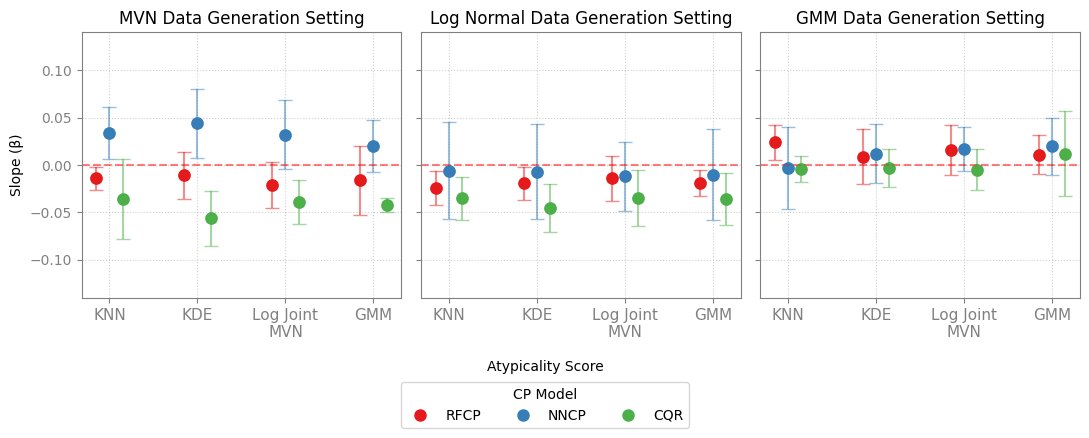

In [3]:
beta_df = compute_beta(true_atypicality=False, silent=True)
display(beta_df.head(5))
plot_betagrouped_by_atypicality(beta_df, "3x3_predicted_atypicality.png")

# Things to fix
* y limits on the second plot - maybe if true_atypicality is true then have it be set to 1 set of y limits, and the other otherwise? 
* silence printing on the renamed run_calibration 
* where is the first plot being saved? 